# Training with Dropout-LSTM

In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Import functions from relative path
from lib.ModelLoader import ModelLoader
from lib.ModelEvaluator import ModelEvaluator
from lib.AttentionLayer import AttentionLayer as Attention
from lib.HyperparameterOptimizer import HyperparameterOptimizer

In [4]:
artifacts_path = os.path.abspath(os.path.join('../artifacts'))
model_loader = ModelLoader(artifacts_path)

## Load dataset

In [5]:
DATASET = '../data/ford/FordA.txt'

series = []
labels = []

with open(DATASET, 'r') as fp:
    for line in fp:
        values = line.strip().split()
        labels.append(float(values[0]) == 1)
        series.append(np.array(values[1:], dtype=np.float32))

# Transform into numpy arrays
series = np.array(series)
labels = np.array(labels)

# It is necessary to transform the array into 3D
series = series.reshape(series.shape[0], series.shape[1], 1)

X_train, X_test, Y_train, Y_test = train_test_split(series, labels, test_size=0.3)

print('Train: %d' % len(X_train))
print('Test: %d' % len(X_test))
print('Data loaded!')

Train: 2520
Test: 1081
Data loaded!


## Model definition

In [6]:
def create_model(input_length, metrics, model_params):
    model = Sequential([
        LSTM(100,
             input_shape=(input_length, 1),
             activation=model_params['lstm_activation'],
             dropout=model_params['lstm_dropout'],
             recurrent_dropout=model_params['recurrent_dropout'],
             return_sequences=True),
        Flatten(),
        Dense(100, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=metrics)
    return model

In [7]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tfa.metrics.F1Score(num_classes=1)
]

# Length of each audio sequence
INPUT_LENGTH = 500

EPOCHS = 8

# Use weights to balance outputs
weights = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
weights = dict(enumerate(weights))

# Find best parameters during the training
optimizer = HyperparameterOptimizer()
tunning_params = {
    'lstm_activation': ['tanh'],
    'lstm_dropout': [0.2, 0.3, 0.5, 0.7],
    'recurrent_dropout': [0.2, 0.3, 0.5, 0.7]
}

best_f1 = -1
history = None
model = None
optimal_params = {}
for p in optimizer.tunning_params_combinations(tunning_params):
    print('- Training with parameters: ', p)

    current_model = create_model(INPUT_LENGTH, METRICS, p)
    current_history = current_model.fit(X_train,
                                        Y_train,
                                        epochs=EPOCHS,
                                        validation_data=(X_test, Y_test),
                                        verbose=1)

    current_f1 = current_history.history['val_f1_score'][-1][0]
    print('  F1-score: %.2f' % current_f1)

    if best_f1 == -1 or best_f1 < current_f1:
        best_f1 = current_f1
        optimal_params = p
        history = current_history
        model = current_model

- Training with parameters:  {'lstm_activation': 'tanh', 'lstm_dropout': 0.2, 'recurrent_dropout': 0.2}
Epoch 1/8
79/79 [==============================] - 95s 1s/step - loss: 0.6490 - accuracy: 0.6329 - precision: 0.6272 - recall: 0.6337 - auc: 0.6879 - f1_score: 0.6614 - val_loss: 0.5754 - val_accuracy: 0.6929 - val_precision: 0.6545 - val_recall: 0.7392 - val_auc: 0.7693 - val_f1_score: 0.6411
Epoch 2/8
79/79 [==============================] - 98s 1s/step - loss: 0.5423 - accuracy: 0.7222 - precision: 0.7141 - recall: 0.7301 - auc: 0.8002 - f1_score: 0.6614 - val_loss: 0.5705 - val_accuracy: 0.6883 - val_precision: 0.6821 - val_recall: 0.6353 - val_auc: 0.7717 - val_f1_score: 0.6411
Epoch 3/8
79/79 [==============================] - 95s 1s/step - loss: 0.4915 - accuracy: 0.7718 - precision: 0.7650 - recall: 0.7767 - auc: 0.8448 - f1_score: 0.6614 - val_loss: 0.5842 - val_accuracy: 0.7151 - val_precision: 0.6706 - val_recall: 0.7784 - val_auc: 0.7925 - val_f1_score: 0.6411
Epoch 4/8
7

79/79 [==============================] - 92s 1s/step - loss: 0.4269 - accuracy: 0.8063 - precision: 0.8021 - recall: 0.8072 - auc: 0.8866 - f1_score: 0.6614 - val_loss: 0.5475 - val_accuracy: 0.7188 - val_precision: 0.7146 - val_recall: 0.6725 - val_auc: 0.8060 - val_f1_score: 0.6411
Epoch 6/8
79/79 [==============================] - 91s 1s/step - loss: 0.3849 - accuracy: 0.8270 - precision: 0.8203 - recall: 0.8321 - auc: 0.9090 - f1_score: 0.6614 - val_loss: 0.5563 - val_accuracy: 0.7225 - val_precision: 0.6923 - val_recall: 0.7412 - val_auc: 0.8081 - val_f1_score: 0.6411
Epoch 7/8
79/79 [==============================] - 91s 1s/step - loss: 0.3194 - accuracy: 0.8651 - precision: 0.8635 - recall: 0.8635 - auc: 0.9385 - f1_score: 0.6614 - val_loss: 0.5849 - val_accuracy: 0.7336 - val_precision: 0.7284 - val_recall: 0.6941 - val_auc: 0.8140 - val_f1_score: 0.6411
Epoch 8/8
79/79 [==============================] - 87s 1s/step - loss: 0.2417 - accuracy: 0.9044 - precision: 0.9016 - recall

Epoch 8/8
79/79 [==============================] - 90s 1s/step - loss: 0.3060 - accuracy: 0.8702 - precision: 0.8726 - recall: 0.8635 - auc: 0.9428 - f1_score: 0.6614 - val_loss: 0.5918 - val_accuracy: 0.7364 - val_precision: 0.7273 - val_recall: 0.7059 - val_auc: 0.8154 - val_f1_score: 0.6411
  F1-score: 0.64
- Training with parameters:  {'lstm_activation': 'tanh', 'lstm_dropout': 0.5, 'recurrent_dropout': 0.5}
Epoch 1/8
79/79 [==============================] - 86s 1s/step - loss: 0.6752 - accuracy: 0.6495 - precision: 0.6376 - recall: 0.6507 - auc: 0.7067 - f1_score: 0.6553 - val_loss: 0.5955 - val_accuracy: 0.6605 - val_precision: 0.6558 - val_recall: 0.5902 - val_auc: 0.7405 - val_f1_score: 0.6411
Epoch 2/8
79/79 [==============================] - 82s 1s/step - loss: 0.5710 - accuracy: 0.6992 - precision: 0.7001 - recall: 0.6843 - auc: 0.7717 - f1_score: 0.6614 - val_loss: 0.5850 - val_accuracy: 0.6781 - val_precision: 0.6378 - val_recall: 0.7353 - val_auc: 0.7635 - val_f1_score: 0

In [8]:
MODEL_NAME = 'ford-lstm'

# Create dir to store the model and store it
print('Saving model...')
model_loader.create_model_dir(MODEL_NAME)
model_loader.save_tf_model(MODEL_NAME, model)

print('Done!')

Saving model...
INFO:tensorflow:Assets written to: /Users/dimasdmm/Documents/Master/Paper_topic/git_project/artifacts/ford-lstm/assets
Done!


## Evaluation

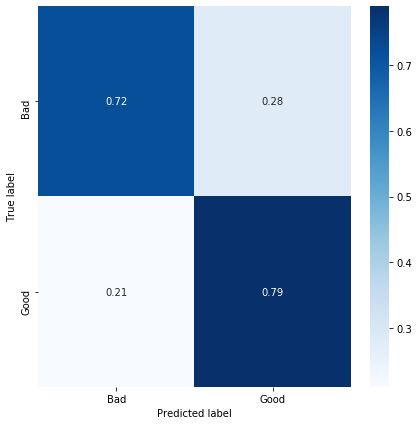

In [9]:
model_evaluator = ModelEvaluator()

Y_pred = model_evaluator.make_predictions(model, X_test)

cm = model_evaluator.compute_confusion_matrix(Y_test, Y_pred)
model_scores = {
    'accuracy': str(history.history['val_accuracy'][-1]),
    'recall': str(history.history['val_recall'][-1]),
    'precision': str(history.history['val_precision'][-1]),
    'f1': str(history.history['val_f1_score'][-1][0]),
    'confusion_matrix': cm.tolist()
}

plt.figure(figsize=(7, 7))
model_evaluator.subplot_confusion_matrix(cm)
plt.show()

In [10]:
accuracy = float(model_scores['accuracy'])
f1 = float(model_scores['f1'])

print('Accuracy: %.2f' % accuracy)
print('F1-Score: %.2f' % f1)

Accuracy: 0.75
F1-Score: 0.64


In [11]:
print('Saving evaluation results...')
model_loader.save_evaluation_results(MODEL_NAME, model_scores)

print('Done!')

Saving evaluation results...
Done!
